In [421]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE,ADASYN

#PARA SVM
from sklearn.datasets import make_blobs
from sklearn.svm import SVC 
from sklearn.datasets import make_circles
from mpl_toolkits import mplot3d


In [422]:
accident = pd.read_csv("RTA Dataset.csv")

In [423]:
# Definindo um limite para valores repetidos
percentagem_not_pedestrian = (accident['Pedestrian_movement'].value_counts(normalize=True) * 100).get('Not a Pedestrian', 0)
percentagem_Normal = (accident['Fitness_of_casuality'].value_counts(normalize=True) * 100).get('Normal', 0)
percentagem_roads = (accident['Road_surface_conditions'].value_counts(normalize=True) * 100).get('Dry', 0)

print(f"A percentagem de ocorrências do valor 'Dry' na coluna 'Rsc' é: {percentagem_roads:.2f}%")
print(f"A percentagem de ocorrências do valor 'Normal' na coluna 'Fitness_of_casuality' é: {percentagem_Normal:.2f}%")
print(f"A percentagem de ocorrências do valor 'Not a Pedestrian' na coluna 'Pedestrian_movement' é: {percentagem_not_pedestrian:.2f}%")

A percentagem de ocorrências do valor 'Dry' na coluna 'Rsc' é: 75.84%
A percentagem de ocorrências do valor 'Normal' na coluna 'Fitness_of_casuality' é: 99.25%
A percentagem de ocorrências do valor 'Not a Pedestrian' na coluna 'Pedestrian_movement' é: 92.48%


In [424]:


# Lista das colunas que deseja remover
colunas_para_remover = ['Sex_of_driver','Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle', 
                        'Defect_of_vehicle', 'Road_allignment', 'Road_surface_conditions', 
                        'Road_surface_type', 'Sex_of_casualty',"Vehicle_driver_relation" 
                        , 'Work_of_casuality', 'Fitness_of_casuality', 
                        'Pedestrian_movement',]

# Removendo as colunas
accident = accident.drop(columns=colunas_para_remover)



In [352]:
#CORRES ESTA FUNCAO SE QUISERES CLASSIFICACAO BINARIA

# Função para converter a variável Accident_severity
def convert_severity(severity):
    if severity in ['Serious Injury', 'Fatal injury']:
        return 0
    elif severity == 'Slight Injury':
        return 1
    else:
        return None  # Caso haja valores inesperados

# Aplicar a função de conversão à coluna Accident_severity
accident['Accident_severity_binary'] = accident['Accident_severity'].apply(convert_severity)

# Verificar o resultado
print(accident[['Accident_severity', 'Accident_severity_binary']].head())
accident = accident.drop(columns=['Accident_severity'])
# Salvar o DataFrame modificado se necessário
# accident.to_csv('seu_arquivo_modificado.csv', index=False)
accident.rename(columns={'Accident_severity_binary': 'Accident_severity'}, inplace=True)


  Accident_severity  Accident_severity_binary
0     Slight Injury                         1
1     Slight Injury                         1
2    Serious Injury                         0
3     Slight Injury                         1
4     Slight Injury                         1


In [425]:
accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Educational_level            11575 non-null  object
 4   Driving_experience           11487 non-null  object
 5   Area_accident_occured        12077 non-null  object
 6   Lanes_or_Medians             11931 non-null  object
 7   Types_of_Junction            11429 non-null  object
 8   Light_conditions             12316 non-null  object
 9   Weather_conditions           12316 non-null  object
 10  Type_of_collision            12161 non-null  object
 11  Number_of_vehicles_involved  12316 non-null  int64 
 12  Number_of_casualties         12316 non-null  int64 
 13  Vehicle_movement             12

In [354]:
print(accident.iloc[9])

Time                                                          17:20:00
Day_of_week                                                     Friday
Age_band_of_driver                                               18-30
Educational_level                                   Junior high school
Driving_experience                                               1-2yr
Area_accident_occured                                Residential areas
Lanes_or_Medians                                     Undivided Two way
Types_of_Junction                                              Y Shape
Light_conditions                                              Daylight
Weather_conditions                                              Normal
Type_of_collision              Collision with roadside-parked vehicles
Number_of_vehicles_involved                                          2
Number_of_casualties                                                 1
Vehicle_movement                                                U-Turn
Casual

In [355]:
print("Duplicates in the dataset: ", accident.duplicated().sum())
print("Null values in the dataset: ",accident.isnull().sum().sum())
# Verifica se há pelo menos três valores nulos em cada linha
null_counts = accident.isnull().sum(axis=1)




Duplicates in the dataset:  0
Null values in the dataset:  3544


In [356]:
# Check for missing values
missing_values = accident.isnull().sum()

# Print columns with missing values, if any
if missing_values.sum() > 0:
    print("Columns with missing values:")
    print(missing_values[missing_values > 0])
else:
    print("No missing values found in the dataset.")

Columns with missing values:
Educational_level        741
Driving_experience       829
Area_accident_occured    239
Lanes_or_Medians         385
Types_of_Junction        887
Type_of_collision        155
Vehicle_movement         308
dtype: int64


In [357]:
accident

,Time,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Area_accident_occured,Lanes_or_Medians,Types_of_Junction,Light_conditions,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Age_band_of_casualty,Casualty_severity,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Above high school,1-2yr,Residential areas,NaN,No junction,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,Moving Backward,1
1,17:02:00,Monday,31-50,Junior high school,Above 10yr,Office areas,Undivided Two way,No junction,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,Overtaking,1
2,17:02:00,Monday,18-30,Junior high school,1-2yr,Recreational areas,other,No junction,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,31-50,3,Changing lane to the left,0
3,1:06:00,Sunday,18-30,Junior high school,5-10yr,Office areas,other,Y Shape,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,18-30,3,Changing lane to the right,1
4,1:06:00,Sunday,18-30,Junior high school,2-5yr,Industrial areas,other,Y Shape,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,Overtaking,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12311,16:15:00,Wednesday,31-50,NaN,2-5yr,Outside rural areas,Undivided Two way,No junction,Daylight,Normal,Vehicle with vehicle collision,2,1,Going straight,na,na,na,No distancing,1
12312,18:00:00,Sunday,Unknown,Elementary school,5-10yr,Outside rural areas,Two-way (divided with broken lines road marking),No junction,Daylight,Normal,Vehicle with vehicle collision,2,1,Other,na,na,na,No distancing,1
12313,13:55:00,Sunday,Over 51,Junior high school,5-10yr,Outside rural areas,Two-way (divided with broken lines road marking),No junction,Daylight,Normal,Vehicle with vehicle collision,1,1,Other,Driver or rider,31-50,3,Changing lane to the right,0
12314,13:55:00,Sunday,18-30,Junior high school,Above 10yr,Office areas,Undivided Two way,No junction,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,1,Other,na,na,na,Driving under the influence of drugs,1


In [358]:
# Definindo as colunas com valores nulos e suas respectivas modas
colunas_com_nulos = ['Educational_level', 
                     'Driving_experience', 'Area_accident_occured', 
                     'Lanes_or_Medians', 'Types_of_Junction', 
                     'Type_of_collision', 'Vehicle_movement']

# Calcular e armazenar as modas para as colunas especificadas
modas = {}
for coluna in colunas_com_nulos:
    moda = accident[coluna].mode()[0] if not accident[coluna].isnull().all() else None
    modas[coluna] = moda

# Preencher os valores nulos com as modas correspondentes
accident.fillna(modas, inplace=True)

# Verificar novamente os valores nulos
missing_values_after = accident.isnull().sum()

# Printar as colunas com valores nulos, se houver
if missing_values_after.sum() > 0:
    print("Columns with missing values after imputation:")
    print(missing_values_after[missing_values_after > 0])
else:
    print("No missing values found in the dataset after imputation.")




No missing values found in the dataset after imputation.


In [359]:
accident

,Time,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Area_accident_occured,Lanes_or_Medians,Types_of_Junction,Light_conditions,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Age_band_of_casualty,Casualty_severity,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Above high school,1-2yr,Residential areas,Two-way (divided with broken lines road marking),No junction,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,Moving Backward,1
1,17:02:00,Monday,31-50,Junior high school,Above 10yr,Office areas,Undivided Two way,No junction,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,Overtaking,1
2,17:02:00,Monday,18-30,Junior high school,1-2yr,Recreational areas,other,No junction,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,31-50,3,Changing lane to the left,0
3,1:06:00,Sunday,18-30,Junior high school,5-10yr,Office areas,other,Y Shape,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,18-30,3,Changing lane to the right,1
4,1:06:00,Sunday,18-30,Junior high school,2-5yr,Industrial areas,other,Y Shape,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,Overtaking,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12311,16:15:00,Wednesday,31-50,Junior high school,2-5yr,Outside rural areas,Undivided Two way,No junction,Daylight,Normal,Vehicle with vehicle collision,2,1,Going straight,na,na,na,No distancing,1
12312,18:00:00,Sunday,Unknown,Elementary school,5-10yr,Outside rural areas,Two-way (divided with broken lines road marking),No junction,Daylight,Normal,Vehicle with vehicle collision,2,1,Other,na,na,na,No distancing,1
12313,13:55:00,Sunday,Over 51,Junior high school,5-10yr,Outside rural areas,Two-way (divided with broken lines road marking),No junction,Daylight,Normal,Vehicle with vehicle collision,1,1,Other,Driver or rider,31-50,3,Changing lane to the right,0
12314,13:55:00,Sunday,18-30,Junior high school,Above 10yr,Office areas,Undivided Two way,No junction,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,1,Other,na,na,na,Driving under the influence of drugs,1


In [361]:
# Select numerical columns only
numerical_columns = accident.select_dtypes(include=['int64', 'float64'])

# Define a function to detect outliers using IQR method
def detect_outliers(df):
    outliers = pd.DataFrame(columns=df.columns)

    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers[col] = (df[col] < lower_bound) | (df[col] > upper_bound)
    
    return outliers

# Detect outliers
outliers = detect_outliers(numerical_columns)

# Print columns with outliers, if any
if outliers.any().any():
    print("Columns with outliers:")
    print(outliers.sum())
else:
    print("No outliers found in the numerical columns.")


Columns with outliers:
Number_of_vehicles_involved    3976
Number_of_casualties            720
Accident_severity              1901
dtype: int64


Class distribution:
Accident_severity
1    10415
0     1901
Name: count, dtype: int64


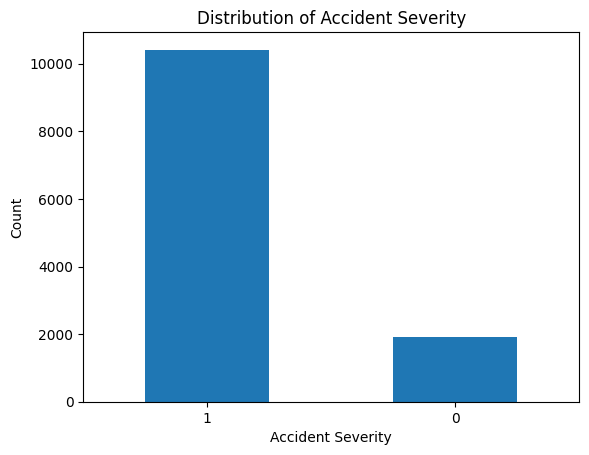

In [362]:
# Assuming 'Accident_severity' is your target variable
severity_counts = accident['Accident_severity'].value_counts()

# Print class distribution
print("Class distribution:")
print(severity_counts)

# Plot class distribution
severity_counts.plot(kind='bar', rot=0)
plt.xlabel('Accident Severity')
plt.ylabel('Count')
plt.title('Distribution of Accident Severity')
plt.show()

C:\Users\gabri\AppData\Local\Temp\ipykernel_15164\3835690370.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_data = accident.groupby('Day_of_week').size()


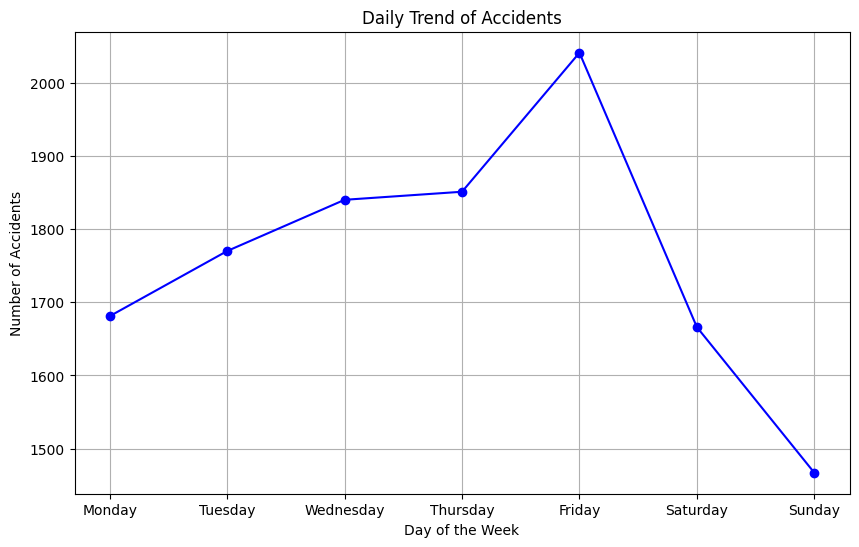

In [83]:
# Convert 'Day_of_week' column to categorical type to ensure proper ordering
accident['Day_of_week'] = pd.Categorical(accident['Day_of_week'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

# Aggregate data by day of the week
daily_data = accident.groupby('Day_of_week').size()

# Plot daily trend
plt.figure(figsize=(10, 6))
daily_data.plot(kind='line', marker='o', color='b')
plt.title('Daily Trend of Accidents')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.show()


In [363]:
# Function to extract the hour portion of the time string and convert it into an integer
def convert_to_hours(time_str):
    hour = int(time_str.split(':')[0])
    return hour

# Add 'hour' column to the DataFrame
accident['hour'] = accident['Time'].apply(convert_to_hours)

# Remove the 'Time' column if you no longer need it
accident.drop(columns=['Time'], inplace=True)

# Reorganize column order to move 'hour' column to the front
accident_final = accident[['hour'] + [col for col in accident.columns if col != 'hour']]

# Display the first few rows of the DataFrame
print(accident_final.head())

# Convert 'Day_of_week' column to categorical type to ensure proper ordering
accident['hour'] = pd.Categorical(accident['hour'], categories=range(24), ordered=True) # ae 24 horas hihihi



   hour Day_of_week Age_band_of_driver   Educational_level Driving_experience  \
0    17      Monday              18-30   Above high school              1-2yr   
1    17      Monday              31-50  Junior high school         Above 10yr   
2    17      Monday              18-30  Junior high school              1-2yr   
3     1      Sunday              18-30  Junior high school             5-10yr   
4     1      Sunday              18-30  Junior high school              2-5yr   

  Area_accident_occured                                  Lanes_or_Medians  \
0     Residential areas  Two-way (divided with broken lines road marking)   
1          Office areas                                 Undivided Two way   
2    Recreational areas                                             other   
3          Office areas                                             other   
4      Industrial areas                                             other   

  Types_of_Junction       Light_conditions Weather

In [364]:
# Check Data Types
print("Data types:")
print(accident.dtypes)

Data types:
Day_of_week                      object
Age_band_of_driver               object
Educational_level                object
Driving_experience               object
Area_accident_occured            object
Lanes_or_Medians                 object
Types_of_Junction                object
Light_conditions                 object
Weather_conditions               object
Type_of_collision                object
Number_of_vehicles_involved       int64
Number_of_casualties              int64
Vehicle_movement                 object
Casualty_class                   object
Age_band_of_casualty             object
Casualty_severity                object
Cause_of_accident                object
Accident_severity                 int64
hour                           category
dtype: object


In [365]:
for col in accident.select_dtypes(['category']).columns:
    # Verificar se os dados na coluna categórica são numéricos
    if pd.api.types.is_numeric_dtype(accident[col].cat.categories):
        accident[col] = accident[col].astype('int64')




In [366]:
accidentoo = accident.select_dtypes(include=['object'])
accinum = accident.select_dtypes(include=['int64', 'float64'])



In [367]:
accident_Final = pd.concat([accidentoo, accinum], axis=1)
accident_Final

,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Area_accident_occured,Lanes_or_Medians,Types_of_Junction,Light_conditions,Weather_conditions,Type_of_collision,Vehicle_movement,Casualty_class,Age_band_of_casualty,Casualty_severity,Cause_of_accident,Number_of_vehicles_involved,Number_of_casualties,Accident_severity,hour
0,Monday,18-30,Above high school,1-2yr,Residential areas,Two-way (divided with broken lines road marking),No junction,Daylight,Normal,Collision with roadside-parked vehicles,Going straight,na,na,na,Moving Backward,2,2,1,17
1,Monday,31-50,Junior high school,Above 10yr,Office areas,Undivided Two way,No junction,Daylight,Normal,Vehicle with vehicle collision,Going straight,na,na,na,Overtaking,2,2,1,17
2,Monday,18-30,Junior high school,1-2yr,Recreational areas,other,No junction,Daylight,Normal,Collision with roadside objects,Going straight,Driver or rider,31-50,3,Changing lane to the left,2,2,0,17
3,Sunday,18-30,Junior high school,5-10yr,Office areas,other,Y Shape,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,Pedestrian,18-30,3,Changing lane to the right,2,2,1,1
4,Sunday,18-30,Junior high school,2-5yr,Industrial areas,other,Y Shape,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,na,na,na,Overtaking,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12311,Wednesday,31-50,Junior high school,2-5yr,Outside rural areas,Undivided Two way,No junction,Daylight,Normal,Vehicle with vehicle collision,Going straight,na,na,na,No distancing,2,1,1,16
12312,Sunday,Unknown,Elementary school,5-10yr,Outside rural areas,Two-way (divided with broken lines road marking),No junction,Daylight,Normal,Vehicle with vehicle collision,Other,na,na,na,No distancing,2,1,1,18
12313,Sunday,Over 51,Junior high school,5-10yr,Outside rural areas,Two-way (divided with broken lines road marking),No junction,Daylight,Normal,Vehicle with vehicle collision,Other,Driver or rider,31-50,3,Changing lane to the right,1,1,0,13
12314,Sunday,18-30,Junior high school,Above 10yr,Office areas,Undivided Two way,No junction,Darkness - lights lit,Normal,Vehicle with vehicle collision,Other,na,na,na,Driving under the influence of drugs,2,1,1,13


In [368]:
print(accidentoo.iloc[0])

Day_of_week                                                        Monday
Age_band_of_driver                                                  18-30
Educational_level                                       Above high school
Driving_experience                                                  1-2yr
Area_accident_occured                                   Residential areas
Lanes_or_Medians         Two-way (divided with broken lines road marking)
Types_of_Junction                                             No junction
Light_conditions                                                 Daylight
Weather_conditions                                                 Normal
Type_of_collision                 Collision with roadside-parked vehicles
Vehicle_movement                                           Going straight
Casualty_class                                                         na
Age_band_of_casualty                                                   na
Casualty_severity                     

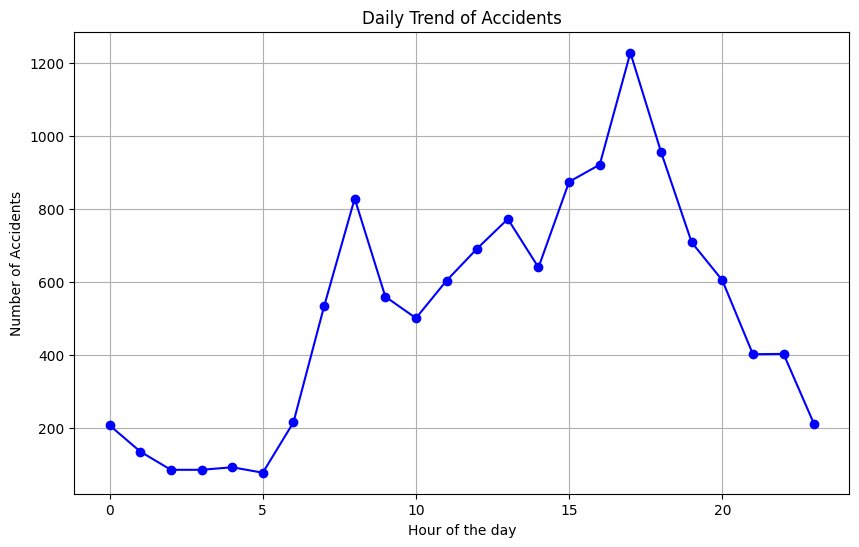

In [369]:
# Aggregate data by day of the week
daily_data = accident.groupby('hour').size()
# Plot daily trend
plt.figure(figsize=(10, 6))
daily_data.plot(kind='line', marker='o', color='b')
plt.title('Daily Trend of Accidents')
plt.xlabel('Hour of the day')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.show()


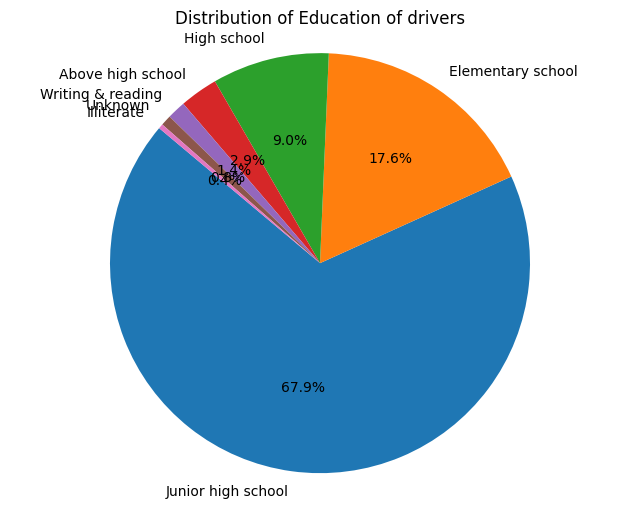

In [370]:
# Assuming 'accident' is your DataFrame containing the data
# and 'Sex_of_driver' is the column you want to visualize

# Calculate the counts for each category
sex_counts = accident['Educational_level'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 6))
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Education of drivers')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
#CRAAZZYYY 65.8 so tem educação de junior high school (aprox entre 12 e 15 anos de idade nessa educacao)


In [371]:
# Get the list of column names in the DataFrame
columns = accidentoo.columns

# Iterate over each column except 'hour'
for col in columns:  # Skip the 'hour' column
    print(f'Category of {col}')
    unique_values = accidentoo[col].unique()
    for j, val in enumerate(unique_values):
        accidentoo[col].replace({val: j}, inplace=True)  # Replace values with their index
        print(j, val)
    print('--------------------------------')

# Now the 'hour' column appears first in the DataFrame
print(accident.head())  # Display the first few rows of the DataFrame

Category of Day_of_week
0 Monday
1 Sunday
2 Friday
3 Wednesday
4 Saturday
5 Thursday
6 Tuesday
--------------------------------
Category of Age_band_of_driver
0 18-30
1 31-50
2 Under 18
3 Over 51
4 Unknown
--------------------------------
Category of Educational_level
0 Above high school
1 Junior high school
2 Elementary school
3 High school
4 Unknown
5 Illiterate
6 Writing & reading
--------------------------------
Category of Driving_experience
0 1-2yr
1 Above 10yr
2 5-10yr
3 2-5yr
4 No Licence
5 Below 1yr
6 unknown
--------------------------------
Category of Area_accident_occured
0 Residential areas
1 Office areas
2   Recreational areas
3  Industrial areas
4 Other
5  Church areas
6   Market areas
7 Unknown
8 Rural village areas
9  Outside rural areas
10  Hospital areas
11 School areas
12 Rural village areasOffice areas
13 Recreational areas
--------------------------------
Category of Lanes_or_Medians
0 Two-way (divided with broken lines road marking)
1 Undivided Two way
2 other
3 

C:\Users\gabri\AppData\Local\Temp\ipykernel_15164\680846633.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  accidentoo[col].replace({val: j}, inplace=True)  # Replace values with their index
C:\Users\gabri\AppData\Local\Temp\ipykernel_15164\680846633.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', Tr

0 na
1 Driver or rider
2 Pedestrian
3 Passenger
--------------------------------
Category of Age_band_of_casualty
0 na
1 31-50
2 18-30
3 Under 18
4 Over 51
5 5
--------------------------------
Category of Casualty_severity
0 na
1 3
2 2
3 1
--------------------------------
Category of Cause_of_accident
0 Moving Backward
1 Overtaking
2 Changing lane to the left
3 Changing lane to the right
4 Overloading
5 Other
6 No priority to vehicle
7 No priority to pedestrian
8 No distancing
9 Getting off the vehicle improperly
10 Improper parking
11 Overspeed
12 Driving carelessly
13 Driving at high speed
14 Driving to the left
15 Unknown
16 Overturning
17 Turnover
18 Driving under the influence of drugs
19 Drunk driving
--------------------------------
  Day_of_week Age_band_of_driver   Educational_level Driving_experience  \
0      Monday              18-30   Above high school              1-2yr   
1      Monday              31-50  Junior high school         Above 10yr   
2      Monday            

In [372]:
for col in accident.columns:
    print(f"Coluna '{col}': {accident[col].dtype}")

Coluna 'Day_of_week': object
Coluna 'Age_band_of_driver': object
Coluna 'Educational_level': object
Coluna 'Driving_experience': object
Coluna 'Area_accident_occured': object
Coluna 'Lanes_or_Medians': object
Coluna 'Types_of_Junction': object
Coluna 'Light_conditions': object
Coluna 'Weather_conditions': object
Coluna 'Type_of_collision': object
Coluna 'Number_of_vehicles_involved': int64
Coluna 'Number_of_casualties': int64
Coluna 'Vehicle_movement': object
Coluna 'Casualty_class': object
Coluna 'Age_band_of_casualty': object
Coluna 'Casualty_severity': object
Coluna 'Cause_of_accident': object
Coluna 'Accident_severity': int64
Coluna 'hour': int64


In [373]:
accident_Final = pd.concat([accidentoo, accinum], axis=1)
accident_Final

,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Area_accident_occured,Lanes_or_Medians,Types_of_Junction,Light_conditions,Weather_conditions,Type_of_collision,Vehicle_movement,Casualty_class,Age_band_of_casualty,Casualty_severity,Cause_of_accident,Number_of_vehicles_involved,Number_of_casualties,Accident_severity,hour
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,1,17
1,0,1,1,1,1,1,0,0,0,1,0,0,0,0,1,2,2,1,17
2,0,0,1,0,2,2,0,0,0,2,0,1,1,1,2,2,2,0,17
3,1,0,1,2,1,2,1,1,0,1,0,2,2,1,3,2,2,1,1
4,1,0,1,3,3,2,1,1,0,1,0,0,0,0,1,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12311,3,1,1,3,9,1,0,0,0,1,0,0,0,0,8,2,1,1,16
12312,1,4,2,2,9,0,0,0,0,1,11,0,0,0,8,2,1,1,18
12313,1,3,1,2,9,0,0,0,0,1,11,1,1,1,3,1,1,0,13
12314,1,0,1,1,1,1,0,1,0,1,11,0,0,0,18,2,1,1,13


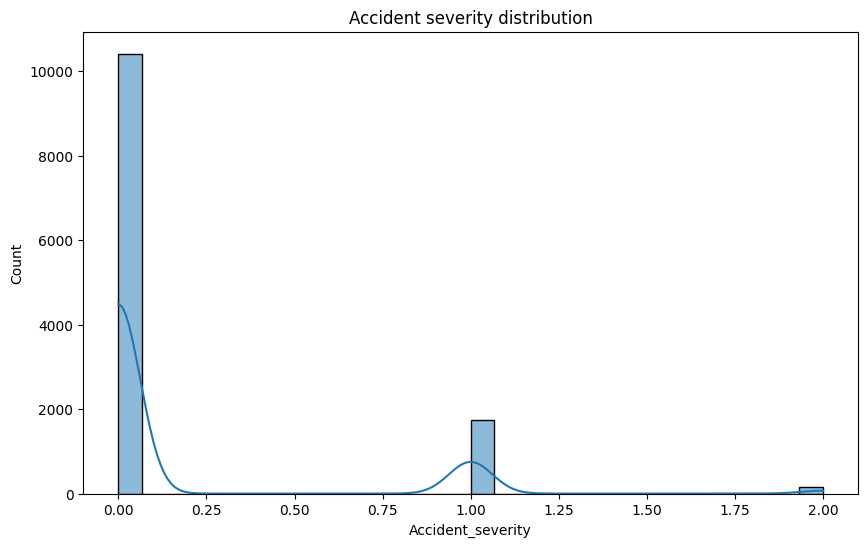

In [322]:
# Histogram 
df=accident_Final
plt.figure(figsize=(10, 6)) #Set the figure size

sns.histplot(df['Accident_severity'],bins=30, kde=True) #Histogram 

plt.title('Accident severity distribution') #Histogram title

plt.show() #Showing Histogram 

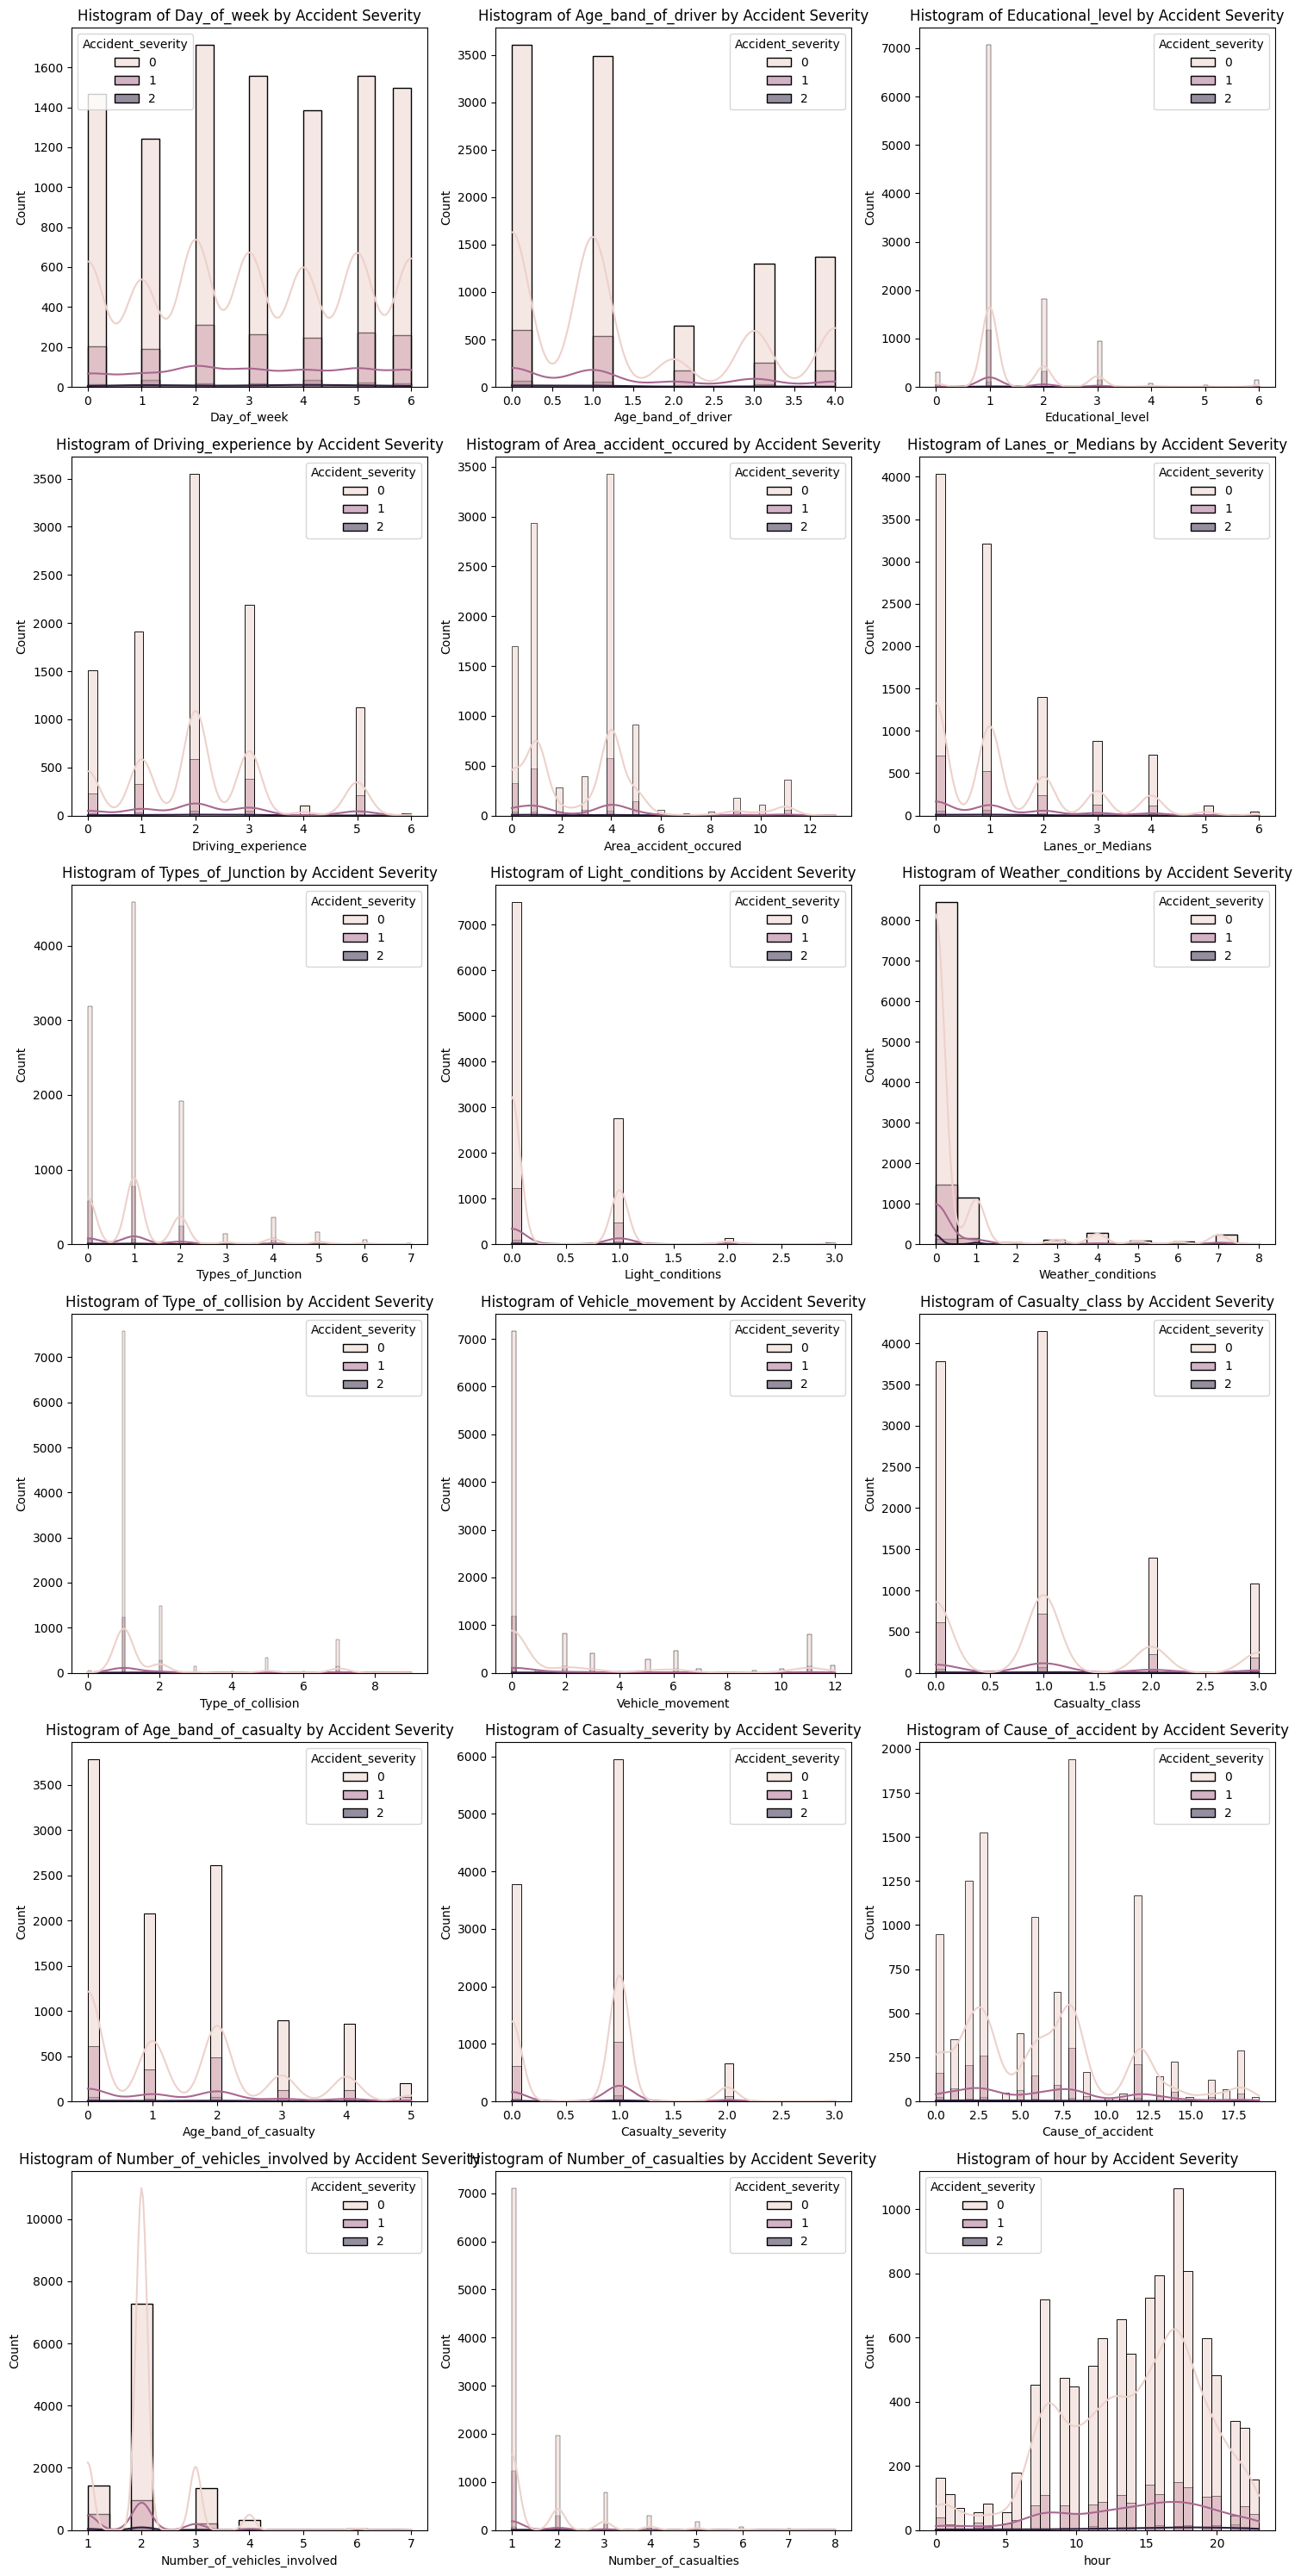

In [323]:
import math
# Determinar o número de linhas e colunas para a disposição dos subplots
num_cols = len(colunas_x)
num_rows = math.ceil(num_cols / 3)  # Define o número de colunas para cada linha

# Criar múltiplos histogramas para cada coluna em relação a 'Accident_severity'
plt.figure(figsize=(15, 5 * num_rows))  # Define o tamanho da figura

for i, coluna in enumerate(colunas_x):
    plt.subplot(num_rows, 3, i + 1)  # Define a posição do subplot na grade
    sns.histplot(x=coluna, hue='Accident_severity', data=df, kde=True)
    plt.title(f'Histogram of {coluna} by Accident Severity')

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

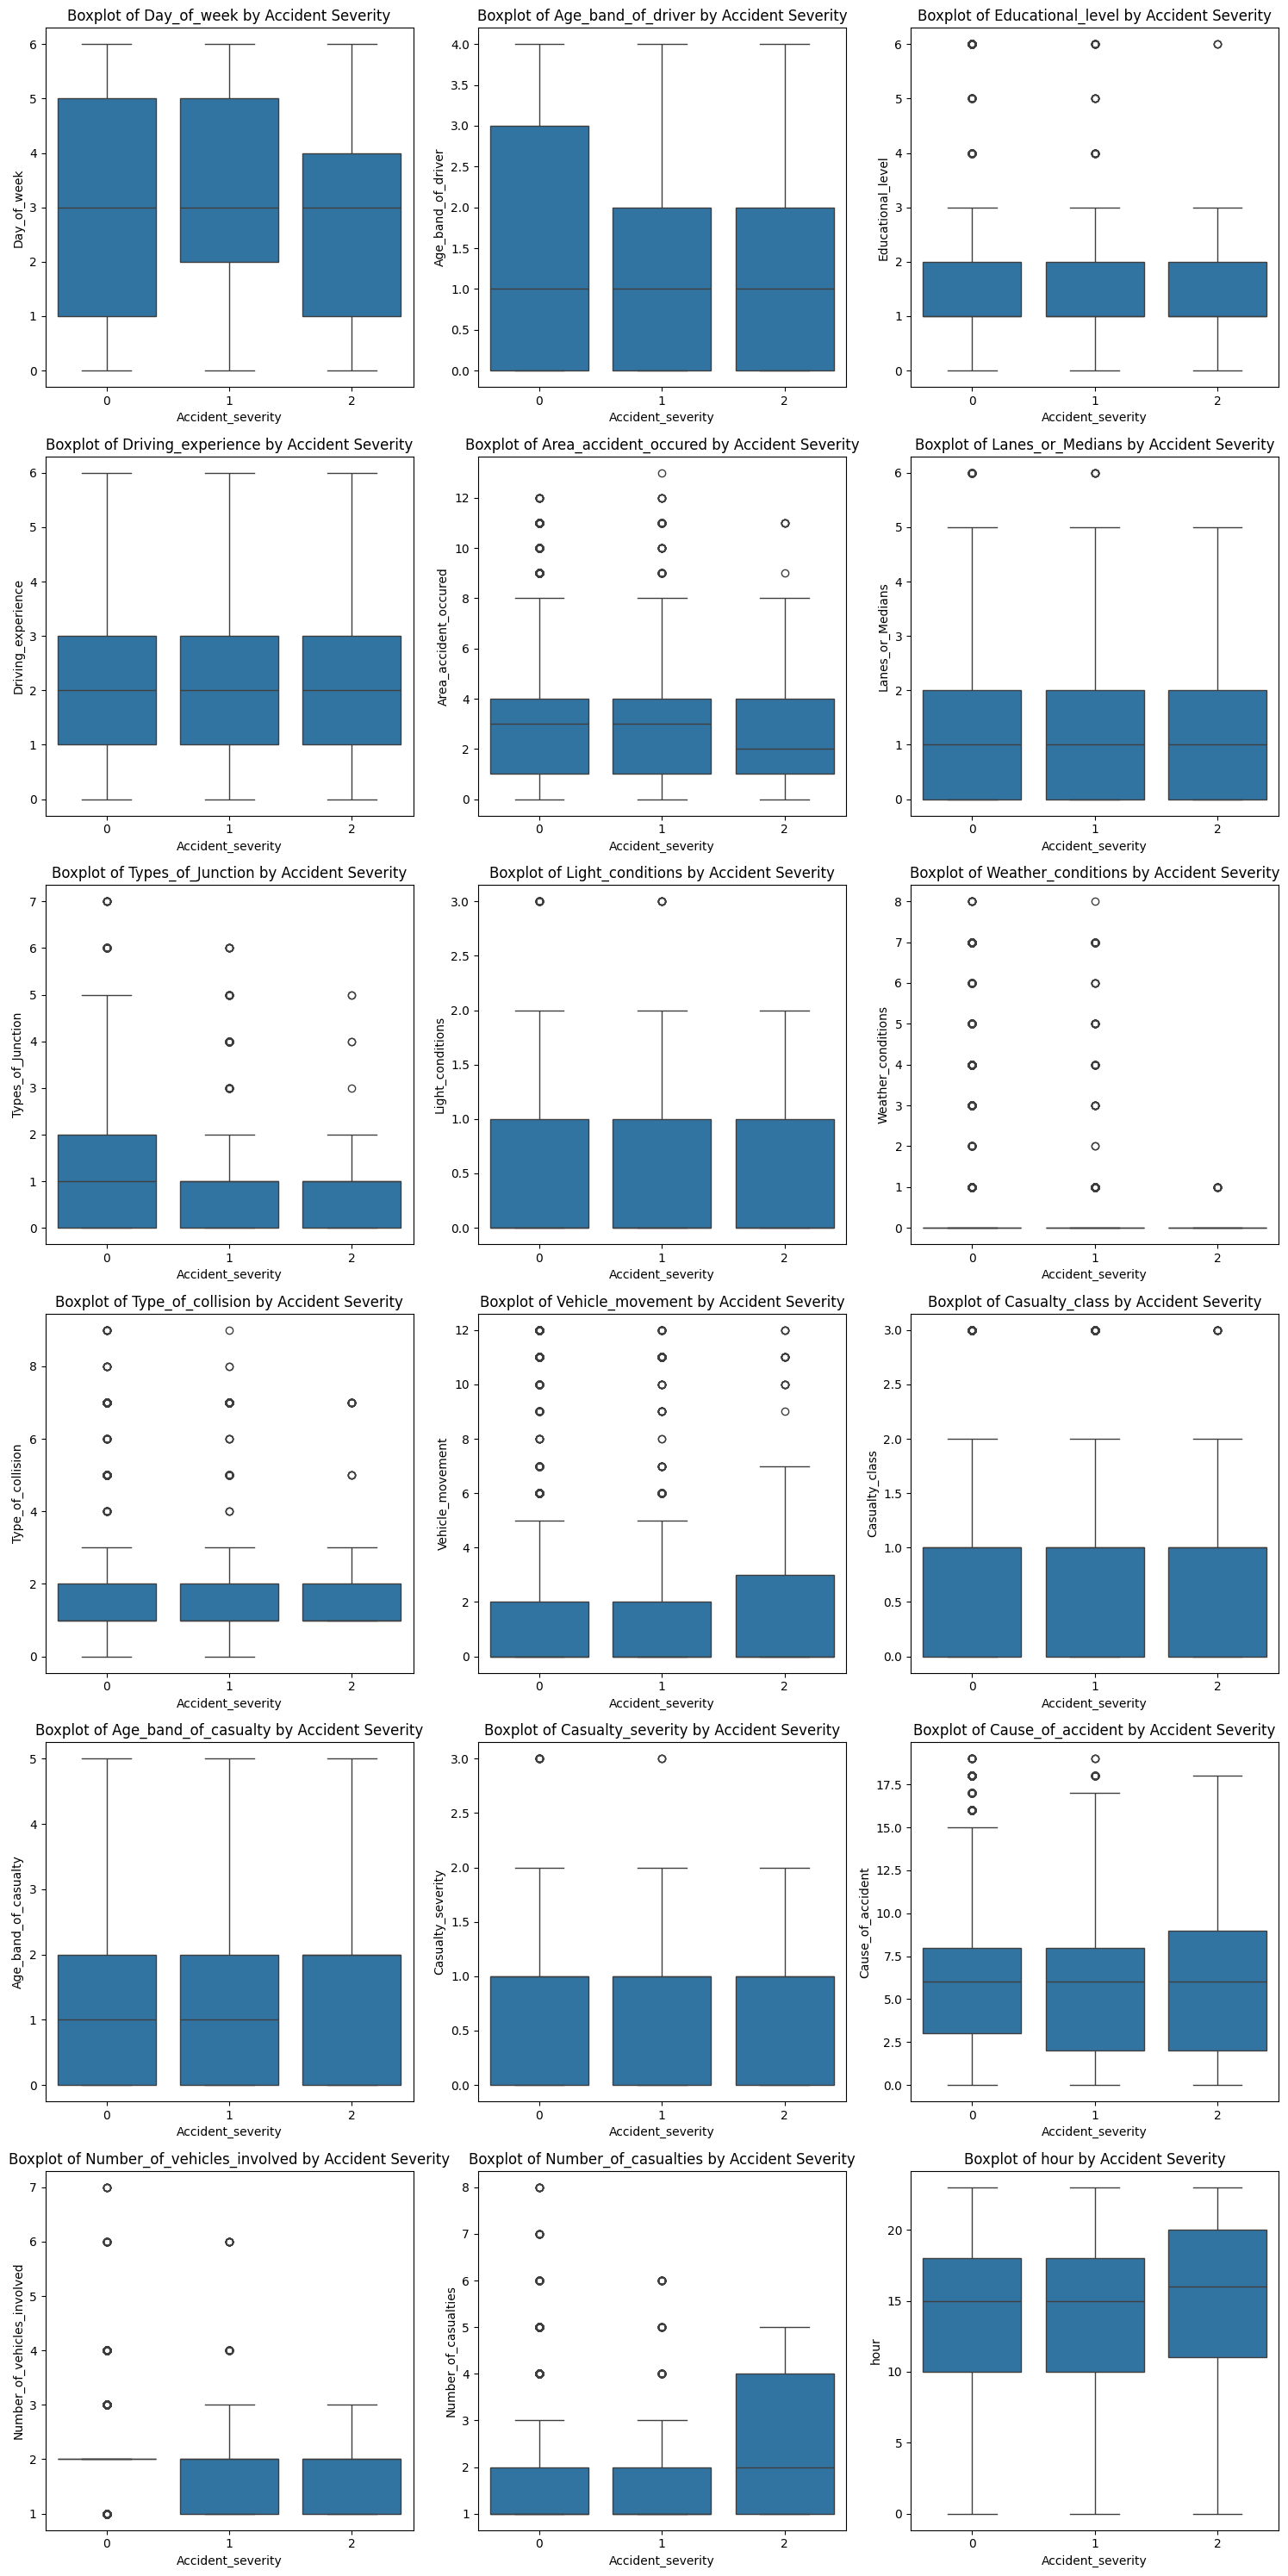

In [290]:
# Obter todas as colunas, exceto 'Accident_severity'
colunas_x = df.drop('Accident_severity', axis=1).columns

# Determinar o número de linhas e colunas para a disposição dos subplots
num_cols = len(colunas_x)
num_rows = math.ceil(num_cols / 3)  # Define o número de colunas para cada linha

# Criar múltiplos boxplots para cada coluna em relação a 'Accident_severity'
plt.figure(figsize=(15, 5 * num_rows))  # Define o tamanho da figura

for i, coluna in enumerate(colunas_x):
    plt.subplot(num_rows, 3, i + 1)  # Define a posição do subplot na grade
    sns.boxplot(x='Accident_severity', y=coluna, data=df)
    plt.title(f'Boxplot of {coluna} by Accident Severity')

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

<Figure size 640x480 with 0 Axes>

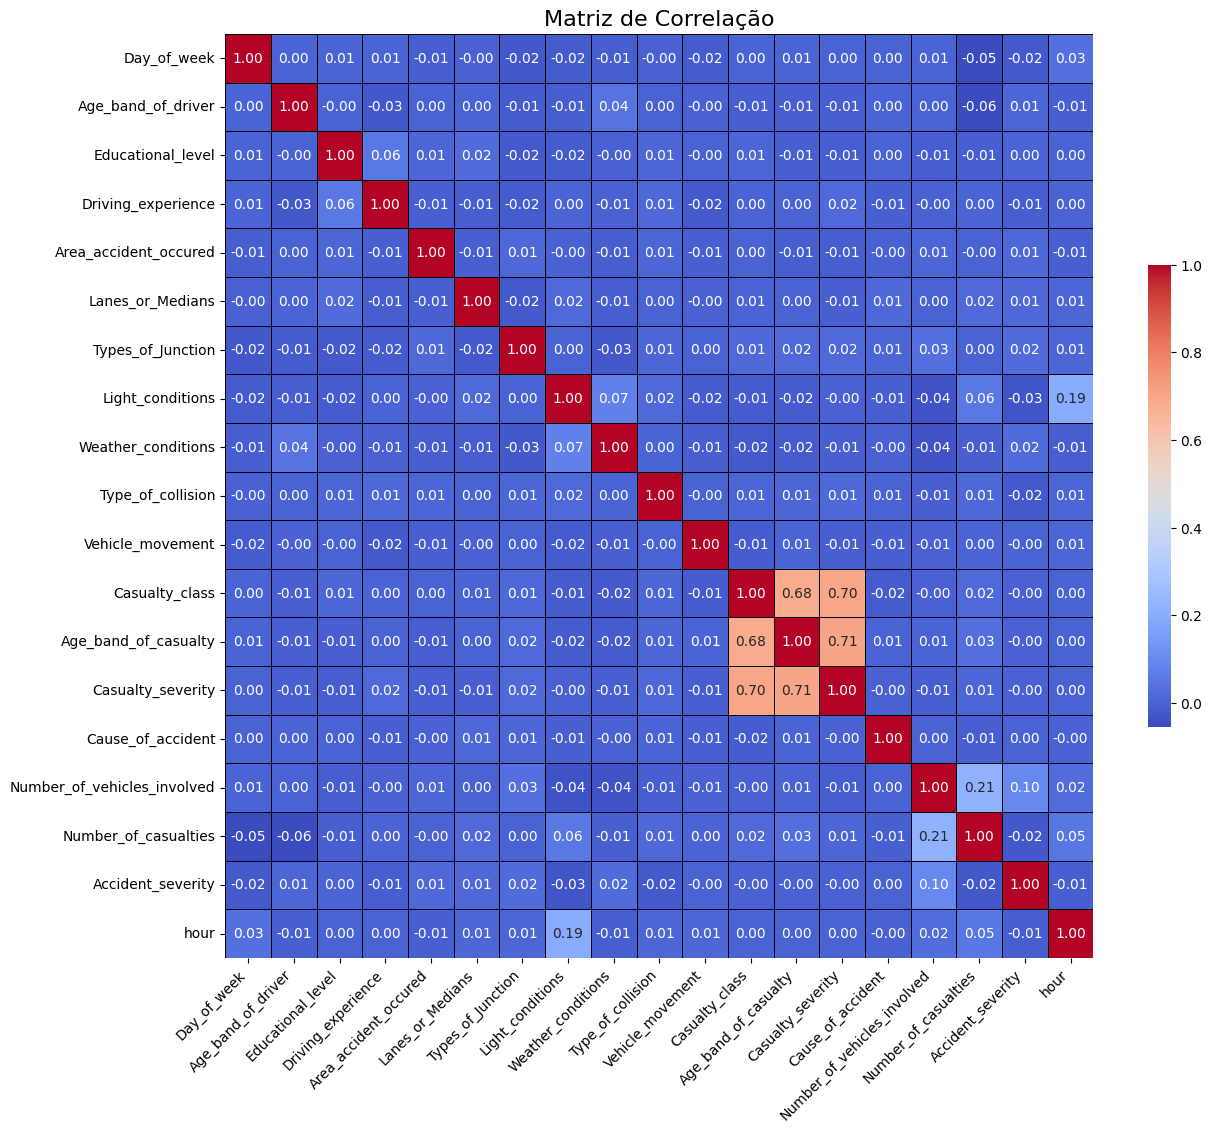

In [374]:
# Supondo que 'accident_Final' seja seu DataFrame contendo colunas numéricas
# Remover colunas não numéricas, se houver
numeric_columns = accident_Final.select_dtypes(include=['int64', 'float64'])

# Calcular a matriz de correlação
correlation_matrix = numeric_columns.corr()
# Salvar a figura
plt.savefig('matriz_correlacao.png', dpi=300, bbox_inches='tight')

# Plotar a matriz de correlação como um heatmap
plt.figure(figsize=(14, 12))  # Aumentar o tamanho da figura
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
            linewidths=0.5, linecolor='black', cbar_kws={'shrink': 0.5})
plt.title('Matriz de Correlação', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotacionar rótulos do eixo x
plt.yticks(rotation=0)  # Manter rótulos do eixo y sem rotação
plt.show()

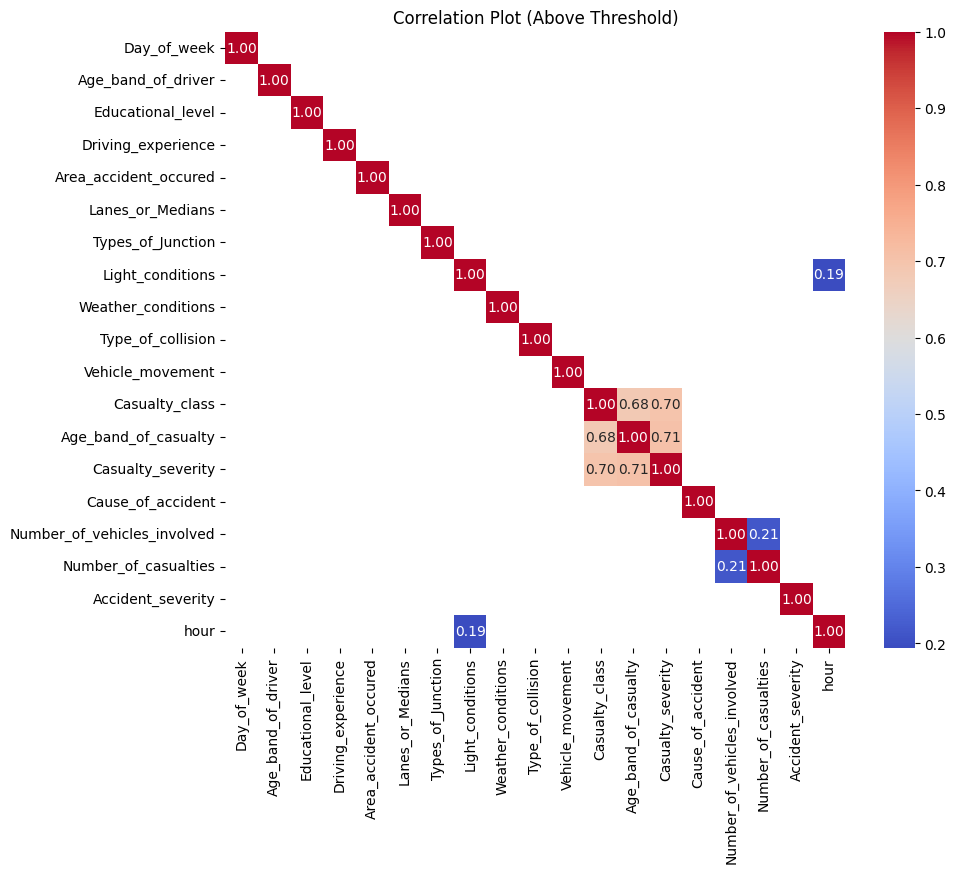

In [375]:

# Assuming 'accident' is your DataFrame containing numerical columns
# Drop non-numeric columns if any
numeric_columns = accident_Final.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Set the threshold for correlation
threshold = 0.1

# Filter correlations above the threshold
high_corr = correlation_matrix[abs(correlation_matrix) > threshold]

# Plot correlation matrix as a heatmap for filtered correlations
plt.figure(figsize=(10, 8))
sns.heatmap(high_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot (Above Threshold)')
plt.show()


In [420]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Carregar e pré-processar o dataset
accident_encoded = pd.get_dummies(accident_Final)
X = accident_encoded.drop('Accident_severity', axis=1)
y = accident_encoded['Accident_severity']

# Dividir os dados em conjuntos de treino e teste (usando uma fração menor para testes rápidos)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33, stratify=y)

# Aplicar SMOTE para balancear as classes no conjunto de treino
smote = SMOTE(random_state=33)
X_resampled, y_resampled = smote.fit_resample(x_train, y_train)

# Normalizar os dados
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
x_test = scaler.transform(x_test)

# Definir modelos MLP com complexidade reduzida
mlp1 = MLPClassifier(hidden_layer_sizes=(50,), activation='logistic', solver='adam', max_iter=200, random_state=30)
mlp2 = MLPClassifier(hidden_layer_sizes=(25, 25), activation='logistic', solver='adam', max_iter=200, random_state=30)
mlp3 = MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', solver='adam', max_iter=200, random_state=30)

# Criar o ensemble VotingClassifier com processamento paralelo
ensemble = VotingClassifier(estimators=[
    ('mlp1', mlp1), 
    ('mlp2', mlp2), 
    ('mlp3', mlp3)
], voting='soft', n_jobs=-1)

# Treinar o modelo ensemble
ensemble.fit(X_resampled, y_resampled)

# Prever no conjunto de teste
y_pred = ensemble.predict(x_test)

# Imprimir métricas de avaliação
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.7066305818673884
              precision    recall  f1-score   support

           0       0.22      0.34      0.27       570
           1       0.87      0.77      0.82      3125

    accuracy                           0.71      3695
   macro avg       0.54      0.56      0.54      3695
weighted avg       0.77      0.71      0.73      3695



In [405]:
accident_encoded = pd.get_dummies(accident_Final)
X = accident_encoded.drop('Accident_severity', axis=1)
y = accident_encoded['Accident_severity']


In [416]:
# Carregar e pré-processar o dataset

# Dividir os dados em conjuntos de treino e teste (usando uma fração menor para testes rápidos)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33, stratify=y)

# Aplicar SMOTE para balancear as classes no conjunto de treino
smote = SMOTE(random_state=33)
X_resampled, y_resampled = smote.fit_resample(x_train, y_train)

In [417]:
# Answer here
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_resampled, y_resampled)

GaussianNB()

In [418]:
# Answer here
y_pred = gnb.predict(x_test)

In [419]:
# Answer here
report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', conf_matrix)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy Score:', accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.46      0.25       570
           1       0.86      0.58      0.69      3125

    accuracy                           0.56      3695
   macro avg       0.51      0.52      0.47      3695
weighted avg       0.75      0.56      0.62      3695

Confusion Matrix:
 [[ 265  305]
 [1313 1812]]
Accuracy Score: 0.5621109607577808


In [340]:
x = accident_Final.drop(['Accident_severity'],axis=1) #Creating x to contain our features except the target class
y = accident_Final.Accident_severity #Creating y just to contain our target variable

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=30) #Splitting the data to train and test



In [343]:
from imblearn.over_sampling import SMOTE


smote = SMOTE(random_state=33)

# Aplicar o SMOTE aos dados
X_resampled, y_resampled = smote.fit_resample(X, y)



In [344]:
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=33)

In [254]:
#essemble



mlp1 = MLPClassifier(hidden_layer_sizes=(100,), activation='logistic',solver='adam',batch_size='auto', max_iter=2000, tol=0.0001,random_state=30)
mlp2 = MLPClassifier(hidden_layer_sizes=(50, 50), activation='logistic',solver='adam',batch_size='auto', max_iter=2000, tol=0.0001,random_state=30)
mlp3 = MLPClassifier(hidden_layer_sizes=(200,), activation='logistic',solver='adam',batch_size='auto', max_iter=2000, tol=0.0001,random_state=30)
mlp4 = MLPClassifier(hidden_layer_sizes=(30,15), activation='logistic',solver='adam',batch_size='auto', max_iter=2000, tol=0.0001,random_state=30)
mlp5 = MLPClassifier(hidden_layer_sizes=(10,5), activation='logistic',solver='adam',batch_size='auto', max_iter=2000, tol=0.0001,random_state=30)
mlp6 = MLPClassifier(hidden_layer_sizes=(200,100), activation='logistic',solver='adam',batch_size='auto', max_iter=2000, tol=0.0001,random_state=30)


ensemble = VotingClassifier(estimators=[('mlp1', mlp1), ('mlp2', mlp2), ('mlp3', mlp3), ('mlp4', mlp4), ('mlp5', mlp5), ('mlp6', mlp6)], voting='soft')

ensemble.fit(x_train, y_train)
y_pred = ensemble.predict(x_test)

In [345]:
mlp = MLPClassifier(hidden_layer_sizes=(30,15), activation='logistic',solver='adam',batch_size='auto', max_iter=2000, tol=0.0001,random_state=30)
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)

c:\Users\gabri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [346]:
print('Class labels:', np.unique(y_test))

print('Misclassified samples: %d' % (y_test != y_pred).sum())

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

cf_matrix = confusion_matrix(y_test,y_pred) #Creating the confusion matrix

print(cf_matrix) #Printing the confusion matrix

Class labels: [0 1 2]
Misclassified samples: 1795
Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.74      0.77      0.75      3110
           1       0.77      0.68      0.73      3157
           2       0.90      0.97      0.94      3107

    accuracy                           0.81      9374
   macro avg       0.81      0.81      0.81      9374
weighted avg       0.81      0.81      0.81      9374

[[2396  577  137]
 [ 813 2162  182]
 [  34   52 3021]]


SVM ANALISE

In [ ]:
#Normalizing data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#Applying RandomUnderSampler to train data with strategy auto
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
x_train_undersampled, y_train_undersampled = under_sampler.fit_resample(x_train, y_train)

#Defining parameters for grid search
param_grid = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10, 100], 'class_weight': ['balanced']},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'class_weight': ['balanced']},
    {'kernel': ['poly'], 'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'degree': [2, 3, 4], 'class_weight': ['balanced']}
]

#Creating SVM model
svm = SVC()

#Realizing grid search
grid_search = GridSearchCV(svm, param_grid, cv=7, scoring='accuracy', n_jobs=-1, refit=True)
grid_search.fit(x_train_undersampled, y_train_undersampled)

#Printing best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

#Evaluating the model on test set
y_pred = grid_search.predict(x_test)
y_pred_train = grid_search.predict(x_train)

print('Misclassified samples: %d' % (y_test != y_pred).sum())  #Misclassified samples

#Misclassified indexes
misclassified_indexes = np.where(y_test != y_pred)[0]
print(f"Incorrect predictions indexes: {misclassified_indexes}")
